1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stat
import scipy.integrate as si
import pandas as pd
from matplotlib.ticker import MaxNLocator

Scipy integrate method:  397.67063681180093
Middle point rectangle integration:  359.05554465007674


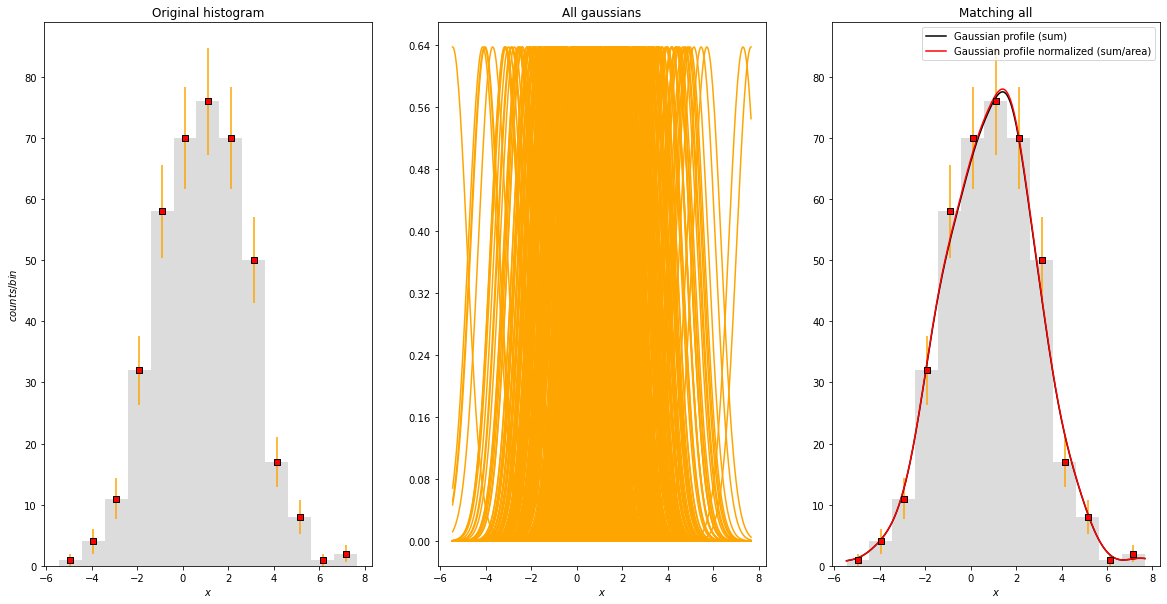

In [7]:
#variables definition
N = 400
mean = 1 
sigma = 2
x = np.random.normal(loc = mean, scale = sigma, size = N)
bins = 13

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,10))

ax1.set_title('Original histogram')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$counts/bin$')
ax1.yaxis.set_major_locator(MaxNLocator(integer = True))

counts, bins, _ = ax1.hist(x, bins = bins, color = 'gainsboro')
mid = 1/2 * (bins[1:] + bins[:-1])

ax1.errorbar(mid,
             counts,
             yerr=np.sqrt(counts),
             marker='s',
             fmt='ko',
             ecolor='orange',
             mfc='red')

#===============
ax2.set_title('All gaussians')
ax2.set_xlabel('$x$')
ax2.yaxis.set_major_locator(MaxNLocator())

mesh = np.linspace(x.min(), x.max(), num = N)
gaussians = np.zeros((N,N))
standard_sigma = 1.06 * x.std() * x.size**(-1/5.)

for i in range(N):
    gaussians[i,:] = stat.norm.pdf(mesh, loc = x[i], scale = standard_sigma)
    ax2.plot(mesh, gaussians[i,:], 'orange')

#===============
ax3.set_title('Matching all')
ax3.set_xlabel('$x$')
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))

gauss_sum = np.sum(gaussians, axis = 0)
ax3.hist(x, bins = bins, color = 'gainsboro')
ax3.errorbar(mid,
             counts,
             yerr=np.sqrt(counts),
             marker='s',
             fmt='ko',
             mfc='red',
             ecolor='orange')
AUC = si.trapz(gauss_sum, dx = (x.max() - x.min()) / N)
ax3.plot(mesh, gauss_sum, color = 'black', label = 'Gaussian profile (sum)')
ax3.plot(mesh, gauss_sum / AUC * N, color = 'red', label = 'Gaussian profile normalized (sum/area)')
ax3.legend()

middle_point_integral = 0
for i in range(len(mid)):
    middle_point_integral += mid[i] * counts[i]
    
print('Scipy integrate method: ', AUC)
print('Middle point rectangle integration: ', middle_point_integral)

#fig.savefig('fig.pdf')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


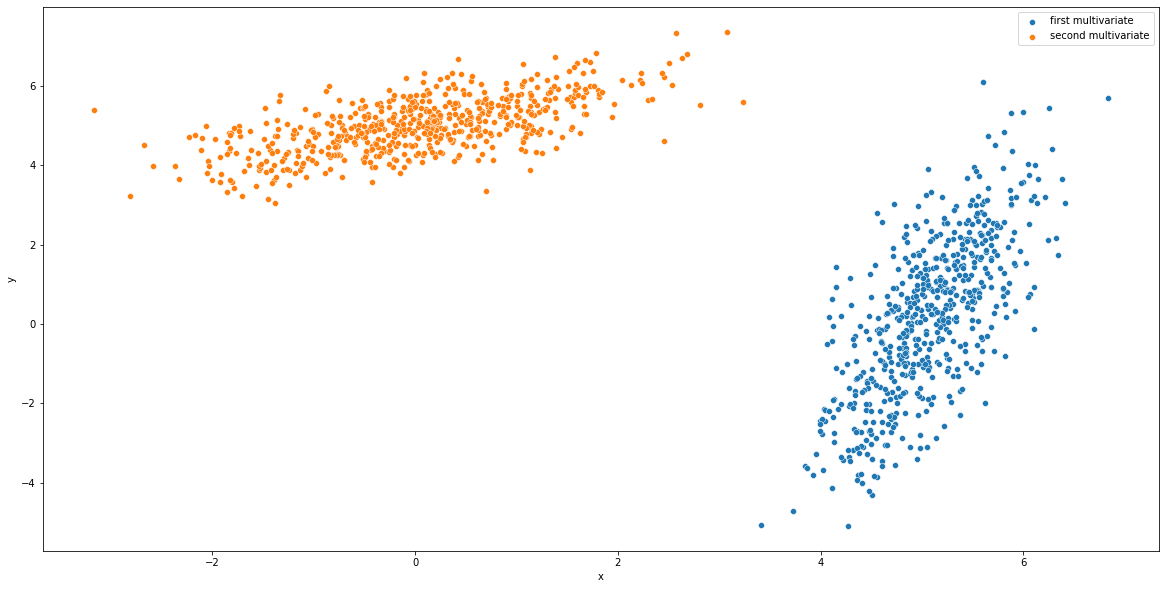

In [13]:
import seaborn as sns

N = 600
mean_1 = [5,0]
mean_2 = [0,5]
cov_1 = [[0.5,2],[0.5,3]]
cov_2 = [[0.5,0.5],[1.2,0.5]]
twodgauss_1 = np.random.multivariate_normal(mean_1, cov_1, N)
twodgauss_2 = np.random.multivariate_normal(mean_2, cov_2, N)
twodgauss_1.shape

df1 = pd.DataFrame(twodgauss_1, columns = ["x", "y"])
df2 = pd.DataFrame(twodgauss_2, columns = ["x", "y"])

fig, ax = plt.subplots(figsize = (20,10))
sns.scatterplot(data = df1, x = 'x', y = 'y', ax = ax, label = 'first multivariate');
sns.scatterplot(data = df2, x = 'x', y = 'y', ax = ax, label = 'second multivariate');
ax.legend()

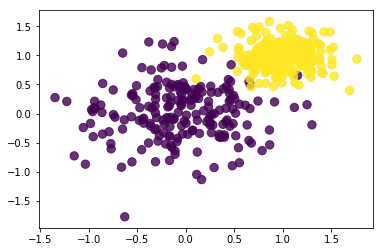

In [14]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [15]:
#! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
data = pd.DataFrame(np.load('residuals_261.npy', allow_pickle = True).item())

In [16]:
#I inspect the dataset: I find residuals and distances
data.head(5)

,residuals,distances
0,1.10,16.0
1,-1.95,6.3
2,-7.20,3.4
3,-4.15,8.4
4,-6.59,1.7


In [17]:
df_clean = data[abs(data['residuals']) < 2]
df_clean.describe()

,residuals,distances
count,10489.000000,10489.000000
mean,-0.121878,9.954824
std,0.439143,5.847142
min,-2.000000,0.000000
25%,-0.280000,4.700000
50%,-0.100000,10.000000
75%,0.070000,15.100000
max,1.992857,24.900000


In [18]:
 slope, intercept, r_value, p_value, std_err = stat.linregress(df_clean['distances'], df_clean['residuals'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


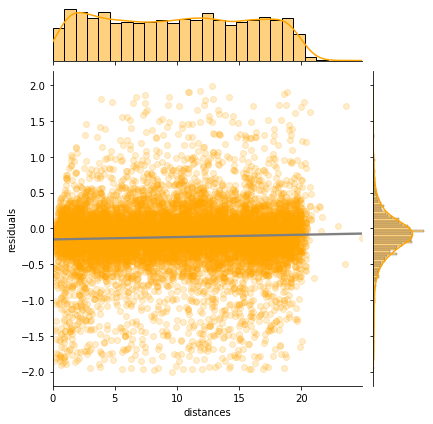

In [38]:
plot = sns.jointplot("distances",
                     "residuals",
                     data = df_clean,
                     kind = "reg",
                     color='orange',
                     joint_kws={'line_kws': {'color': 'gray'},
                                'scatter_kws': dict(alpha = 0.2)})

In [35]:
x = np.array([i + 1/2 for i in range(20)]) #in the middle
y = np.zeros(20)
erry = np.zeros(20)

for i in range(20):
    y[i] = df_clean['residuals'][(df_clean['distances'] > i) & (df_clean['distances'] < i + 1)].mean()
    erry[i] = df_clean['residuals'][(df_clean['distances'] > i) & (df_clean['distances'] < i + 1)].std()
    
print(y)
print(erry)

[-0.24681325 -0.12989732 -0.17463489 -0.16243032 -0.13319177 -0.13942494
 -0.10424032 -0.07879165 -0.10530914 -0.10090854 -0.03311745 -0.0914637
 -0.07868601 -0.13182509 -0.14368135 -0.12177526 -0.13945171 -0.16790314
 -0.12161063 -0.05222069]
[0.48732756 0.42182345 0.4262629  0.40975528 0.38458806 0.39801896
 0.43612876 0.46095775 0.44381378 0.42008083 0.43645245 0.47160631
 0.50159408 0.46371072 0.46224375 0.45553885 0.41060295 0.42074562
 0.40744313 0.37218506]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


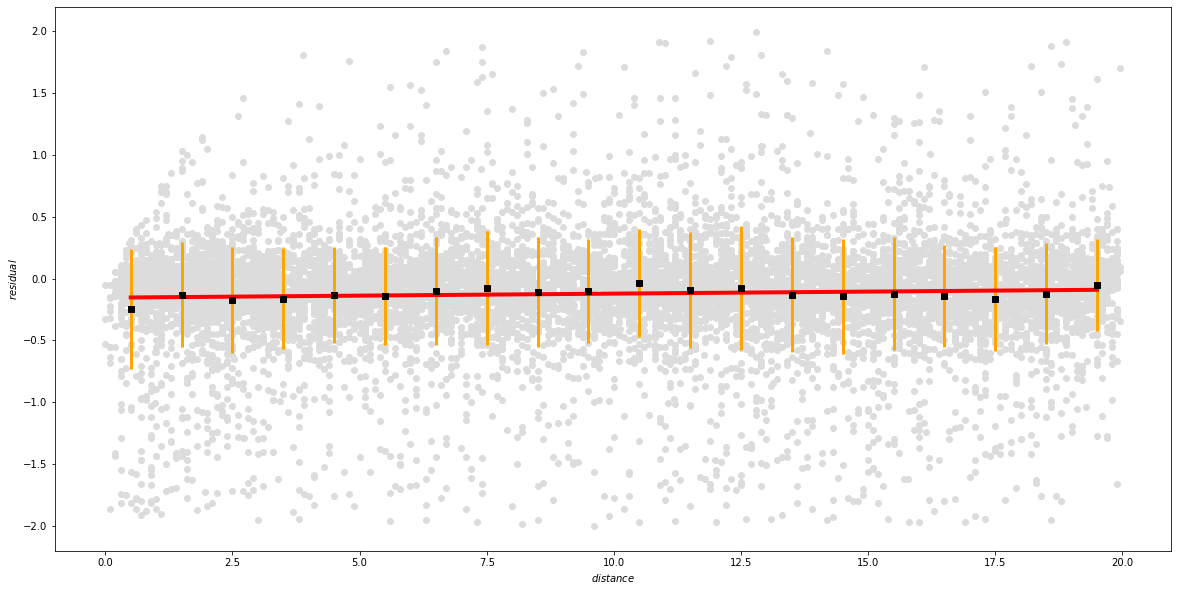

In [36]:
df1 = df_clean[data['distances'] < 20]
y_predicted = intercept + slope * x

fig, ax = plt.subplots(figsize = (20,10))
ax.set_xlabel('$distance$')
ax.set_ylabel('$residual$')
ax.scatter(df1['distances'], df1['residuals'], color = 'gainsboro')
ax.plot(x, y_predicted, color = 'red', linewidth = 4)
ax.errorbar(x, y,
            yerr = erry,
            marker ='s',
            fmt ='ko',
            ecolor = 'orange',
            mfc ='black',
            linewidth=3)
plt.show()

Text(27.125, 0.5, 'residuals')

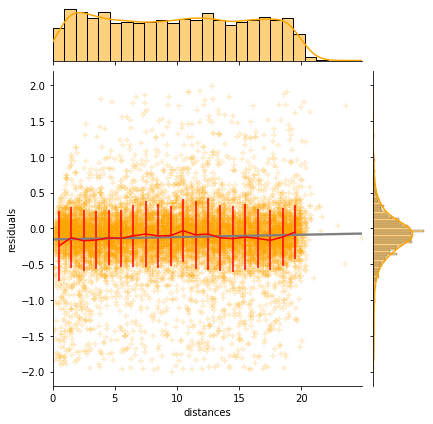

In [39]:
a = sns.jointplot(x = "distances",
                  y = "residuals",
                  data = df_clean,
                  marker = '+',
                  kind = 'reg',
                  color='orange',
                  joint_kws={'line_kws': {'color': 'gray'},
                             'scatter_kws': dict(alpha = 0.2)})
plt.errorbar(x, y, yerr = erry, color = 'r')
plt.xlabel('distances')
plt.ylabel('residuals')